# Topic Modeling through Latent Dirichlet Allocation

**Outline**

* [Introduction](#intro)
* [Implementation using gensim](#example)
* [Math behind LDA](#math)
* [Reference](#refer)

In [471]:
%reload_ext watermark
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import re, string
import matplotlib.pyplot as plt

%watermark -a 'Johnny' -d -t -v -p pandas,numpy,nltk,gensim,re

Johnny 2019-01-29 13:52:00 

CPython 3.6.3
IPython 6.1.0

pandas 0.20.3
numpy 1.13.3
nltk 3.2.4
gensim 3.4.0
re 2.2.1


---

# <a id='intro'>Introduction</a>

There are many time that we would have a large collection of documents (let's call them corpus) and would like to somehow identify the topics among these documents. Since the corpus might be large, it would be very difficult for us to know how to define those topics that can cover each of the documents, not to mention to hand label them one by one. Furthermore, each documents can potentially be related to multiple topics. For example, Online booking platform Airbnb may want to [discover and classifying in-app message](https://medium.com/airbnb-engineering/discovering-and-classifying-in-app-message-intent-at-airbnb-6a55f5400a0c) to help them better understand guest intent in order to provide a more seamless communication experience for both their guests and hosts. A meesage like 
> Could you recommend some things to do in the area? We were looking to go to a public beach or lake

The first sentence, “Could you recommend some things to do in the area?”, is a general ask. However the next sentence in the same message, “We were looking to go to a public beach or lake”, apparently has very specific intent. The message does not neatly fit into either label (specific or generic) as a whole.

This is exactly where Latent Dirichlet Allocation(LDA) can come into play. Unlike other unsupervised algorithms that  assume one data point belongs to one cluster, LDA discover potential topics in the large corpus with 
* **Input**: a lot of documents
* **Output**: 
    * Topics with the top words. For example, top 10 words for topic 1 is delicious, recommend, popular, ...etc (We can use these top words to define a topic such as positive experience or intent)
    * Distribution to each document. For example, doc1 with 40% topic1, 30% topic2, ...etc)

# <a id='example'>Implementation using gensim</a>

In this post, similar to Airbnb's in-app message intent example, we would like to identify the customer intent using the [Customer Support related tweets on Twitter with over 3 million tweets and replies from the biggest brands](https://www.kaggle.com/thoughtvector/customer-support-on-twitter/home). Among all the tweets, these are the top brand by volume
<img src="pic/top_brands.png" style="width: 620px;height: 380px;"/>

We can see that AppleSupport accounts for the largest volume. Since customer intent and the questions people ask for each brand might be quite different, we would like to firstly focus on the tweets related to @AppleSupport. Topic Modeling for other brands can be done following the same sturcture. 

The goal here is to help AppleSupport
* better serve their customer's need by automatically label the tweets with topics and potentially help them to expedite the response time
* identify what are the top issues from the tweet that people send to customer support

<img src="pic/twitter_apple.png" style="width: 520px;height: 560px;"/>

> **Read Data**

In [56]:
df_raw = pd.read_csv('data/twcs.csv')

In [453]:
# there are totally 2.8 million tweets
print(df_raw.shape)

# see dataframe
df_raw.head()

(2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


* **tweet_id**: A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.
* **author_id**: A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.
* **inbound**: Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.
* **created_at**: Date and time when the tweet was sent.
* **text**: Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like \__email\__.
* **response_tweet_id**: IDs of tweets that are responses to this tweet, comma-separated.
* **in_response_to_tweet_id**: ID of the tweet this tweet is in response to, if any.

In [261]:
# let's keep only the tweets that contains @AppleSupport
# Also keep only non-responding tweet (in_response_to_tweet_id=NA) to include tweets with some degree of intent
# These are the tweets that Apple Support get on Twitter, which are the tweets that we want to identify the intent
df = df_raw[(df_raw['text'].str.contains('@AppleSupport')) & (df_raw['in_response_to_tweet_id'].isnull())].copy()
df.shape

(50823, 7)

In [262]:
df['year_month'] = df['created_at'].apply(lambda x: x[-4:]+' '+x[4:7])
df['year_month'].value_counts().head(10)

2017 Nov    27103
2017 Oct    21097
2017 Dec     2509
2017 Sep       89
2017 Aug        5
2017 Jan        3
2017 Jun        3
2017 Jul        2
2017 May        2
2017 Apr        2
Name: year_month, dtype: int64

In [263]:
df.to_csv('data/apple.csv',index=False)

There are ~97k tweets, with most of them happens during October to November in 2017.

In [266]:
# let's take a look at those tweets
for i in df['text'].head(10):    
    print(i+'\n')

@AppleSupport why are my I️’s changing not showing up correctly on any of my social media platforms? https://t.co/GyRvpyVnkE

Hey @AppleSupport and anyone else who upgraded to ios11.1, are y’all having issues with capital “I️” in the Mail app? As it puts in “A”?

@115858 @AppleSupport hello are all the lines closed for tonight #help

Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7

@AppleSupport I’ve got a screenshot saying my #iPhoneX is reserved for the 3rd then an email saying it’s the 18th... what happened?

Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤

Hola @AppleSupport necesito urgente la actualización de software. La batería me dura literal medio día 🙍🏼🙇🏼‍♀️

@AppleSupport Hi! What is going on? Has Youtube lost it? What can be done about it? Thanks for the support! https://t.co/T8ZZp4IH6t

@

> **Step 1: Clean the corpus**

In [305]:
# create English stop words list (you can always define your own stopwords)
# add 'applesupport' as stop words since we don't need it in the document
stop_words = set(stopwords.words('english'))
custom_removel = ['applesupport', '115858', '115948', '118936', '116333']
for i in custom_removel:
    stop_words.add(i)

# Create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

In [306]:
df['text']= df['text'].apply(lambda x: x.strip())

In [307]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,year_month
400,700,115854,True,Tue Oct 31 22:16:56 +0000 2017,@AppleSupport why are my I️’s changing not sho...,698,NaN,2017 Oct
413,714,115856,True,Tue Oct 31 22:19:32 +0000 2017,Hey @AppleSupport and anyone else who upgraded...,"712,715",NaN,2017 Oct
421,723,115859,True,Tue Oct 31 22:11:16 +0000 2017,@115858 @AppleSupport hello are all the lines ...,722,NaN,2017 Oct
427,730,115861,True,Tue Oct 31 20:46:35 +0000 2017,"Hello, internet. Can someone explain why this ...","729,731",NaN,2017 Oct
429,733,115863,True,Tue Oct 31 22:16:40 +0000 2017,@AppleSupport I’ve got a screenshot saying my ...,732,NaN,2017 Oct


In [308]:
# lower case
# remove url from doc
# remove stop words from sentences 
# lemmatize verbs and nouns
def clean(doc, lemmatize=True):
    url_free = re.sub(r'https?:\/\/.+/\w+', '', doc, flags=re.MULTILINE)
    tokenized = word_tokenize(url_free.lower())
    stop_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x) and x not in stop_words]
    y = [s for s in stop_free if len(s) > 2] # remove string with length 1
    
    if lemmatize==True:
        lemma_verb = [lemmatizer.lemmatize(word,'v') for word in stop_free]
        lemma_noun = [lemmatizer.lemmatize(word,'n') for word in lemma_verb]
        y = [s for s in lemma_noun if len(s) > 2] # remove string with length 1
    return y

In [310]:
# corpus_clean is a list for tokenized documents (a list of list)
# each list contains the tokenized words in a document
corpus_clean = [clean(doc, lemmatize=True) for doc in list(df['text'])]

In [456]:
corpus_clean[0]

['change', 'show', 'correctly', 'social', 'medium', 'platform']

> **Step 2: Create the dictionary**

In [312]:
# find a unique id for each unique term {term : id}
dictionary = corpora.Dictionary(corpus_clean)

> **Step 3: Convert list of documents (i.e., reviews) into Document Term Matrix**

LDA requires documents to be represented as a bag of words

In [313]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(doc_clean) for doc_clean in corpus_clean]

In [314]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

> **(Optional) Step 3.5: Try using TF-IDF as the weight of bag-of-words for LDA**

In [459]:
from gensim.models import TfidfModel

In [460]:
temp = []
corpus_tfidf = [temp+model[corpus[i]] for i in range(0,len(corpus))]

In [461]:
corpus_tfidf[0]

[(0, 0.2463502022834394),
 (1, 0.420708623603127),
 (2, 0.41010986836319935),
 (3, 0.586073920514529),
 (4, 0.24036958188184429),
 (5, 0.43916460641844418)]

> **Step 4: Run the LDA model on the document term matrix**

In [315]:
# LDA model needs many iterations/passes and a large corpus to work well
# must define the number of topics you want to extract from the corpus
ldamodel_k10 = LdaModel(corpus_tfidf, num_topics=10, id2word = dictionary, passes=10, iterations=2000) # or use corpus

In [462]:
# ldamodel_k10.show_topics()

> **Step 6: For each of the k topics, print the top 10 words**

In [318]:
def get_topic_df(ldamodel, num_topics, num_words):
    """get the top # words per topic dataframe"""
    
    # get the top # words per topic
    top_list = {}
    for i in range(num_topics):
        top_list[i]=[re.sub('[\"]', '',s.split("*")[1]).strip() for s in ldamodel.print_topics(num_topics=num_topics, num_words=num_words)[i][1].split("+")]
  
    return pd.DataFrame(top_list)    

In [319]:
# show the result using not lemmatized corpus with k = 10
ldamodel_k10_df = get_topic_df(ldamodel_k10, 10, 10)
ldamodel_k10_df

,0,1,2,3,4,5,6,7,8,9
0,update,fix,battery,help,screen,que,email,iphone,apple,iphone
1,phone,please,iphone,try,iphone,iphone,iphone,issue,music,get
2,iphone,turn,drain,n't,lock,ring,apple,anyone,question,phone
3,since,type,charge,photo,work,pause,ipad,plus,get,one
4,new,get,life,app,home,11.0.2,check,work,account,apple
5,freeze,phone,update,macbook,explain,wtf,receive,else,box,day
6,time,annoy,die,download,black,heck,take,wifi,help,new
7,keep,letter,hour,mac,button,spotify,thank,problem,mark,contact
8,fix,glitch,phone,sierra,time,entire,much,11.1.2,someone,call
9,get,need,fix,delete,gon,não,way,fix,change,buy


In [565]:
for id in range(100,105):
    print("Original Text:\n" + df.text.iloc[id])
    print('\n')
    print("Tokenize Text:\n" + str(corpus_clean[id]))
    print('\n')    
    print("LDA output:\n" + str(ldamodel_k10_tfidf[corpus_tfidf[id]]))
    print('\n')
    print('============')    

Original Text:
My battery was at 64% and I restarted my phone and now it’s at 52%. WHAT THE FUCK FIX YOUR SHIT IOS 11!!!

cc: @115858 @AppleSupport


Tokenize Text:
['battery', 'restart', 'phone', 'fuck', 'fix', 'shit']


LDA output:
[(0, 0.030052716), (1, 0.030045943), (2, 0.030056933), (3, 0.11591073), (4, 0.030044822), (5, 0.030044878), (6, 0.64367431), (7, 0.030045208), (8, 0.030044822), (9, 0.030079611)]


Original Text:
@115858  @AppleSupport music and podcast “skip” around like a CD, then distorts and clears up in few seconds, only happens after iOS 11


Tokenize Text:
['music', 'podcast', 'skip', 'around', 'like', 'distort', 'clear', 'second', 'happen']


LDA output:
[(0, 0.025963323), (1, 0.025948977), (2, 0.025950326), (3, 0.20343733), (4, 0.025948245), (5, 0.02595426), (6, 0.3126927), (7, 0.025948972), (8, 0.025948245), (9, 0.30220762)]


Original Text:
@AppleSupport my watch has been saying I’ve been averaging 57 minutes, now today it’s 52, I checked and did the math it’s 5

It turns out that there are it's hard to label these topics and this can be due to the following reasons
* There are more 10 categories in all these tweets. We should spend longer time to identify the number of topics that make sense for this document. (Trial & Error)
* Tweets are too short to have multiple topics, we might also want to try lower the number of topics
* Better tune hyperparameters **alpha** and **eta** so that the distribution of the top words and topics can better fit our need. Check out [the blog from Ethen](https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/topic_model/LDA.ipynb#Understanding-the-role-of-LDA-model-hyperparameters) for more information about the effects of these two hyperparamters. In short,
    * **higher alpha makes the document preferences "smoother" over topics** (harder to say one docuemnt belongs to a single topic)
    * **higher eta makes the topic preferences "smoother" over words** (the top 10 words would seem to be less important according to the output probability).

> **See the distribution of Top 1 and Top 2 topics across these tweets**

In [463]:
# keep only text column from the original data frame
df2 = df[['text']].reset_index(drop=True).copy()

# get top 1&2 topic info
top1_list = [sorted(ldamodel_k10_tfidf[corpus_tfidf[id]], key=lambda x:x[1], reverse=True)[0] for id in range(0,len(corpus_tfidf))]
top2_list = [sorted(ldamodel_k10_tfidf[corpus_tfidf[id]], key=lambda x:x[1], reverse=True)[1] for id in range(0,len(corpus_tfidf))]

# add top 1 topic info
top1_labels = ['Top1', 'Top1 Prob']
top1 = pd.DataFrame(top1_list, columns=top1_labels)
df2 = pd.concat([df2, top1], axis=1)

# add top 2 topic info
top2_labels = ['Top2', 'Top2 Prob']
top2 = pd.DataFrame(top2_list, columns=top2_labels)
df2 = pd.concat([df2, top2], axis=1)

df2.head()

,text,Top1,Top1 Prob,Top2,Top2 Prob
0,@AppleSupport why are my I️’s changing not sho...,5,0.517467,9,0.243178
1,Hey @AppleSupport and anyone else who upgraded...,9,0.778293,6,0.024638
2,@115858 @AppleSupport hello are all the lines ...,0,0.541068,2,0.203345
3,"Hello, internet. Can someone explain why this ...",9,0.343718,6,0.327235
4,@AppleSupport I’ve got a screenshot saying my ...,0,0.409176,7,0.238090


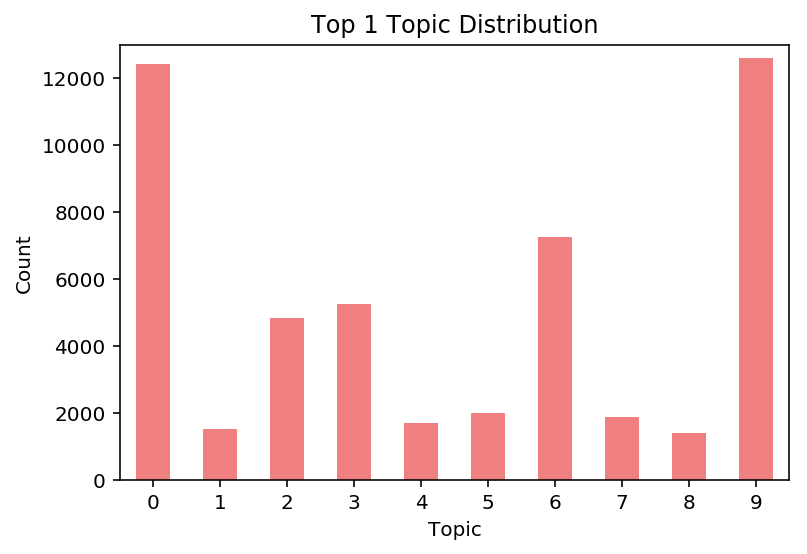

In [535]:
# plot the top 1 topic distribution of tweets
# total weight assigned by each topic to its top 10 words
top_probs = []
n_topics = 10
top_probs = list(df2.Top1.value_counts(sort=False))

ind = np.arange(n_topics)
width = 0.5

fig, ax = plt.subplots()

ax.bar(ind, top_probs, width, color = 'lightcoral')
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Top 1 Topic Distribution')
plt.xlim(-0.5, 9.5)
plt.ylim(0, 13000)
plt.show()

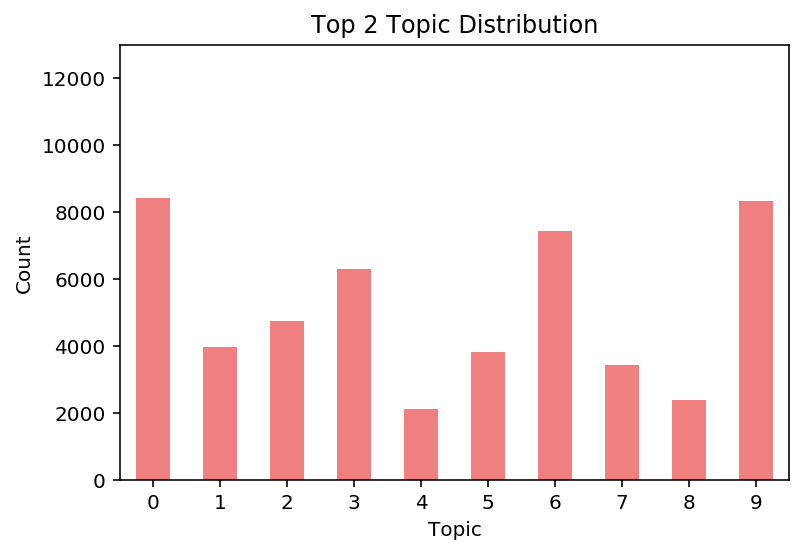

In [534]:
# plot the top 2 topic distribution of tweets
# total weight assigned by each topic to its top 10 words
top_probs = []
n_topics = 10
top_probs = list(df2.Top2.value_counts(sort=False))

ind = np.arange(n_topics)
width = 0.5

fig, ax = plt.subplots()

ax.bar(ind, top_probs, width, color = 'lightcoral')
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Top 2 Topic Distribution')
plt.xlim(-0.5, 9.5)
plt.ylim(0, 13000)
plt.show()

It turns out that the result is not as good as we might expected using this data. Hopefully this exmaple can stll be serve as an example for other applications. Things are worth to try further are:
* Tune hyperparameter **alpha** and **eta**
* Tune number of topics
* Use other brand and see if the result would make more sense
* Remove words that might not related to the potential topics of customer service
* (maybe for apple's customer service, there are just too many things can happen badly. From little detail to system update issues. This data might simply not be a good example for LDA).

# <a id='math'>Math behind LDA</a>

* walk through the math behind LDA (EM step) -- To Be Updated

## <a id='refer'>Reference</a>

* [Topic Modeling from Ethen Liu](https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/topic_model/LDA.ipynb)
* [gensim DOC: TFIDF model](https://radimrehurek.com/gensim/models/tfidfmodel.html)
* [gensim DOC: LDA model](https://radimrehurek.com/gensim/models/ldamodel.html)